In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from IPython.display import display, clear_output

In [2]:
# read out table
otus = pd.read_csv('/home/michaelhoffert/lab-data/datasets/Oliverio_2020a/processed/03_tabletax/seqtab_final.txt', sep='\t', index_col=0)
# grab taxonomy in case we need it
taxonomy = otus['taxonomy']
otus = otus.drop('taxonomy', 1)

In [3]:
# normalize to column sum for relative abundance
otus_norm = otus.divide(otus.sum())

In [4]:
# read metadata
md = pd.read_csv('/home/michaelhoffert/lab-data/datasets/Oliverio_2020a/metadata/Panama_metadata_full_v1.txt', encoding='latin1', sep='\t')

In [5]:
otus_norm.head()

,Alb_0202,Alb_0204,Alb_0303,Alb_0402,Alb_0404,B1_0202,B1_0204,B1_0303,B1_0402,B1_0404,...,She4_0404,SheG_0202,SheG_0204,SheG_0303,SheG_0402,Sob_0202,Sob_0204,Sob_0303,Sob_0402,Sob_0404
#ASV ID,,,,,,,,,,,,,,,,,,,,,
ASV_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.015689,0.001211,0.000000,...,0.048939,0.056733,0.000000,0.130409,0.000000,0.000000,0.0,0.0,0.0,0.000000
ASV_10,0.0,0.0,0.0,0.0,0.0,0.027609,0.00000,0.003954,0.014873,0.000000,...,0.004197,0.022213,0.010171,0.010712,0.010122,0.003016,0.0,0.0,0.0,0.003529
ASV_100,0.0,0.0,0.0,0.0,0.0,0.000000,0.00308,0.001623,0.000000,0.004049,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
ASV_1000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
ASV_10000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [6]:
# define a series to store optimum for each ASV
pH_optima = pd.Series()
# sort by abundance because it's more convenient
abun_order = otus_norm.mean(1).sort_values(ascending=False).index
i = 0
# iterate over each row: get vector of samples abundances for ASV
for index, otu_data in otus_norm.reindex(abun_order).iterrows():
    display(i)
    clear_output(wait=True)
    # merge with metadata
    merged = pd.merge(otu_data, md.set_index('#sampleID'), left_index=True, right_index=True)
    # sort by pH
    merged_sorted = merged.sort_values('pH.water')
    # fit a spline
    spline = UnivariateSpline(merged_sorted['pH.water'], merged_sorted[index])
    # grab spline predictions
    splinevals = spline(merged_sorted['pH.water'][:-1], )
    xvals = merged_sorted['pH.water'][:-1]
    # get the max value
    optimum=xvals[np.argmax(splinevals)]
    # save it
    pH_optima.loc[index] = optimum
    
    # # optional plotting code
    # sns.scatterplot(data=merged, y=index, x='pH.water')
    # plt.plot(xvals, splinevals, color='red')
    # plt.vlines([optimum], np.min(merged[index]), np.max(merged[index]))
    # plt.show()
    
    i += 1

18379

<AxesSubplot:ylabel='Count'>

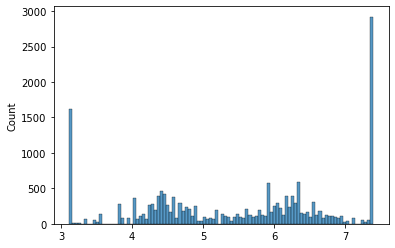

In [9]:
# histogram of the pH optima
sns.histplot(pH_optima, bins=100)

#### Notes
Lots of values at 7, not a fan of that

<AxesSubplot:xlabel='pH.water', ylabel='Count'>

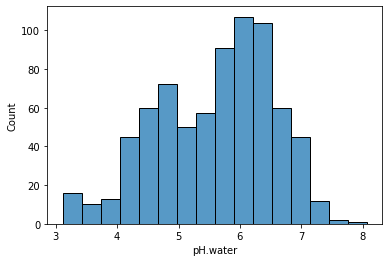

In [11]:
# plot the pH values from the metadata
sns.histplot(md['pH.water'])

In [7]:
# get the results of matching the ASVs to GTDB
to_gtdb = pd.read_csv('/home/michaelhoffert/machine-learning/ph/gtdb_map/Oliverio_2020a_ASVs_to_GTDBr89.tsv', sep='\t', header=None)

In [10]:
# how many ASVs matched?
len(to_gtdb[0].unique())

7750

In [13]:
# Unused placeholder code
# clusters = pd.read_csv('/home/michaelhoffert/phylogenetic/cluster_genome_norfs.tsv.gz', sep='\t')
# subset_clusters = clusters[clusters.domain.eq('B') & clusters.genome.isin(to_gtdb[1].unique())]
# clusters_wide = subset_clusters.set_index(['cl_name', 'genome'])['n'].unstack().fillna(0)
# clusters_wide.shape
# clusters_wide.head()

# To do
* Refine the optimum pH assignment method
* Annotate all GTDB genomes with Pfam (which would be helpful for the geosmin project)
* make the ML input data for all GTDB genomes
* test an ML model  
Noah wants to do a random forest because it has feature importance but I think a deep neural network will be better because I have no clue what features to expect to be information and I'd rather have better predictive performance at this point.

In [18]:
# testing a ML model, method
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# first neural network with keras make predictions

# load the dataset
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10, verbose=0)
# make class predictions with the model
predictions = (model.predict(X) > 0.5).astype(int)
# summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))